In [1]:
import pint
import numpy as np
import matplotlib.pyplot as pl
from fair.constants.general import M_ATMOS
from fair.constants.molwt import AIR as M_AIR
from fair.constants import molwt

class ScmUnitRegistry(pint.UnitRegistry):
    """
    Unit registry class for OpenSCM. Provides some convenience methods to add standard
    unit and contexts.
    """

    def add_standards(self):
        """
        Add standard units.
        Has to be done separately because of pint's weird initializing.
        """
#        self._add_gases(_standard_gases)

        self.define("a = 1 * year = annum = yr")
        self.define("h = hour")
        self.define("d = day")
        self.define("kt = 1000 * t")  # since kt is used for "knot" in the defaults
        self.define('volume_mixing_ratio = [vmr] = vmr')
        self.define('parts_per_million = 1e-6 * volume_mixing_ratio = ppm')
        self.define('parts_per_billion = 1e-9 * volume_mixing_ratio = ppb')
        self.define('parts_per_trillion = 1e-12 * volume_mixing_ratio = ppt')
        self.define('kilometric_ton = kt')

In [2]:
unit = ScmUnitRegistry()
unit.add_standards()

In [3]:
M_ATM = M_ATMOS * unit.kg                       # stick this into the main class method
MW_AIR = molwt.AIR * unit.g / unit.mol          # and this

# # TODO: make this a test

In [4]:
class Species:
    pass
    
    
## TODO: move timestep to Scenario

class GreenhouseGas(Species):
    
#    M_ATMOS = 5.1352e+18 * unit.kg
#    MW_AIR  = 28.97 * unit.g / unit.mol
    
    def __init__(self, radiative_efficiency, reference_concentration, concentration_t0, molecular_weight, name, efficacy=1):
        self.name = name
        self.efficacy = efficacy
        self.radiative_efficiency    = radiative_efficiency
        self.reference_concentration = reference_concentration
        self.concentration_t0        = concentration_t0
        self.molecular_weight        = molecular_weight
        self.kg_to_vmr               = MW_AIR/self.molecular_weight / M_ATM * 1.0 * unit.vmr        
        #if name in library:   # pandas datatable of stats or a csv?
            # load up all the stuff above
            # self.lifetime = library[name].lifetime
            # self.radiative_efficiency = library[name].radiative_efficiency and so on
    
    def set_emissions(self, anthropogenic, natural=0, timestep=1*unit.year, time_points=None):
        self.anthropogenic_emissions = anthropogenic
        self.natural_emissions = natural
        self.emissions = anthropogenic + natural
        self.timestep = timestep
        if time_points is None:
            if hasattr(self.emissions, '__len__'):
                nt = len(self.emissions)
                time_points = (np.arange(nt) + 0.5) * timestep
# ERROR CHECKING: ensure sensible inputs
        self.time_points = time_points
#        return Emissions(anthropogenic, natural, emissions_times, timestep)
    
    def set_concentrations(self, concentrations, timestep=1*unit.year, time_bounds=None):
        self.concentrations = concentrations
        self.timestep = timestep
        if time_bounds is None:
            if hasattr(self.concentrations, '__len__'):
                nt = len(self.concentrations)
                time_bounds = (np.arange(nt) + 0.5) * timestep
# ERROR CHECKING: ensure sensible inputs
        self.time_bounds = time_bounds
#        return Concentrations(concentrations)
        
    def set_lifetime(self, lifetime):
        self.lifetime = lifetime
        
    def calculate_concentrations(self):
        # for GHGs with no temperature feedback or inter-species dependence
        # only makes sense when emissions are defined
        #emissions = self.emissions + self.natural_emissions
        if hasattr(self.emissions, '__len__'):
            nt = len(self.emissions)   # ensures that either emissions or natural_emissions are array - 
                                  # still need to check it is 1D
            emissions = self.emissions
        elif np.isscalar(self.emissions) and hasattr(self.time_points, '__len__'):
            nt = len(self.time_points)
            emissions = self.emissions * np.ones(nt)
        concentrations = np.ones(nt+1) * np.nan * unit.vmr
        time_bounds = self.time_points - self.timestep/2
        time_bounds = np.append(time_bounds, self.time_points[-1] + self.timestep/2)
        
        def _forward(c0, em, ts, lt, vm):   # put this in its own module and import
            c1 = c0*np.exp(-ts/lt) + lt*em*vm * (1.-np.exp(-ts/lt))
            return c1
            
        concentrations[0] = self.concentration_t0
        
        for t in range(nt):
            concentrations[t+1] = _forward(concentrations[t], emissions[t], 
                                         self.timestep, self.lifetime, self.kg_to_vmr)

        self.concentrations = concentrations
        self.time_bounds = time_bounds
#        return Concentrations(concentrations, time_bounds)

    def calculate_forcing(self, scale=1):
        # need checks to determine that scale is scalar or array with same length as concentations
        self.effective_radiative_forcing = (self.concentrations - self.reference_concentration) * self.radiative_efficiency * scale
        self.effective_radiative_forcing.ito(unit.watt / unit.m**2)
#        return EffectiveRadiativeForcing(self.effective_radiative_forcing)

In [5]:
def etminan(co2, ch4, n2o):
    cbar = 0.5*(co2.reference_concentration + co2.concentrations)
    mbar = 0.5*(ch4.reference_concentration + ch4.concentrations)
    nbar = 0.5*(n2o.reference_concentration + n2o.concentrations)
    
    # units really come into their own here
    co2.effective_radiative_forcing = (
        (-2.4e-7/unit.ppm**2*(co2.concentrations - co2.reference_concentration)**2
         + 7.2e-4/unit.ppm*abs(co2.concentrations-co2.reference_concentration) 
         - 2.1e-4/unit.ppb * nbar + 5.36) 
        * np.log(co2.concentrations/co2.reference_concentration)
    ) * unit.watt / unit.m**2
    
    ch4.effective_radiative_forcing = (
        (-1.3e-6/unit.ppb*mbar - 8.2e-6/unit.ppb*nbar + 0.043) 
        * (np.sqrt(ch4.concentrations/unit.ppb) - np.sqrt(ch4.reference_concentration/unit.ppb))
    ) * unit.watt / unit.m**2
    
    n2o.effective_radiative_forcing = (
        (-8.0e-6/unit.ppm*cbar + 4.2e-6/unit.ppb*nbar - 4.9e-6/unit.ppb*mbar + 0.117)
        * (np.sqrt(n2o.concentrations/unit.ppb) - np.sqrt(n2o.reference_concentration/unit.ppb))
    ) * unit.watt / unit.m**2
#    return (
#        EffectiveRadiativeForcing(co2.effective_radiative_forcing), 
#        EffectiveRadiativeForcing(ch4.effective_radiative_forcing),
#        EffectiveRadiativeForcing(n2o.effective_radiative_forcing)
#    )
    
    
class CO2(GreenhouseGas):
    def calculate_forcing(self, ch4, n2o):
        etminan(self, ch4, n2o)


class CH4(GreenhouseGas):
    def calculate_forcing(self, co2, n2o):
        etminan(co2, self, n2o)


class N2O(GreenhouseGas):
    def calculate_forcing(self, co2, ch4):
        #self.effective_radiative_forcing = 
        etminan(co2, ch4, self)#[2]
    
    
# class Emissions:
#     def __init__(self, anthropogenic, natural, emissions_times, timestep):
#         self.anthropogenic_emissions=anthropogenic
#         self.natural_emissions=natural
#         self.emissions=anthropogenic+natural
#         self.emissions_times=emissions_times
#         self.emissions_timestep=timestep
        
        
# class Concentrations:
#     def __init__(self, concentrations, time_bounds):
#         self.concentrations = concentrations
#         self.time_bounds = time_bounds
    
    
# class EffectiveRadiativeForcing:
#     def __init__(self, effective_radiative_forcing):
#         self.effective_radiative_forcing = effective_radiative_forcing
        
        
# class Temperature:
#     def __init__(self, temperature):
#         self.temperature = temperature

/nfs/see-fs-02_users/mencsm/.local/lib/python3.5/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


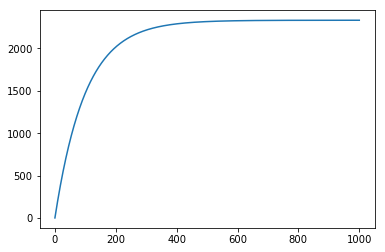

In [6]:
cfc12 = GreenhouseGas(radiative_efficiency=0.32 * unit.watt / unit.m**2 / unit.ppb,
                   reference_concentration=0 * unit.ppt,
                   concentration_t0=0 * unit.ppt,
                   molecular_weight=120.91 * unit.g / unit.mol,
                   name='CFC12')
cfc12.set_emissions(np.ones(1000)*500 * unit.kt / unit.year,
                  natural = 0.00 * unit.kt / unit.year)
#cfc12.set_emissions([500]*1000 * unit.kt / unit.year,
#                  natural = 0.00 * unit.kt / unit.year)
#cfc12.set_emissions(500 * unit.kt / unit.year,
#                  natural = 0.00 * unit.kt / unit.year)
cfc12.set_lifetime(100 * unit.years)
cfc12.calculate_concentrations()
pl.plot(cfc12.time_bounds, cfc12.concentrations.to('ppt'))
# concentrations always returns array of size nt+1

In [7]:
n2o = N2O(
    radiative_efficiency=3.00e-3 * unit.watt / unit.m**2 / unit.ppb,
    reference_concentration=273 * unit.ppb,
    concentration_t0 = 273 * unit.ppb,
    molecular_weight = 44.01 * unit.g / unit.mol,
    name='N2O'
)
n2o.set_concentrations(np.linspace(272,500,1001) * unit.ppb)

In [8]:
ch4 = CH4(
    radiative_efficiency=3.63e-4 * unit.watt / unit.m**2 / unit.ppb,
    reference_concentration=791 * unit.ppb,
    concentration_t0 = 791 * unit.ppb,
    molecular_weight = 16.04 * unit.g / unit.mol,
    name='CH4'  
)
ch4.set_concentrations(np.linspace(791,1800,1001) * unit.ppb)

In [9]:
co2 = CO2(
    radiative_efficiency=1.37e-5 * unit.watt / unit.m**2 / unit.ppb,
    reference_concentration=278 * unit.ppm,
    concentration_t0 = 278 * unit.ppm,
    molecular_weight = 44.01 * unit.g / unit.mol,
    name='CO2'
)
co2.set_concentrations(np.linspace(278,415,1001) * unit.ppm)

In [277]:
# Scenario (attributes forcing, temperature, timestep)
# - Species
# - - GreenhouseGas (attributes emissions, conc, lifetime, GWP, GTP)
# - - - CO2
# - - - CH4
# - - - N2O
# - - - ODS (attributes EESC)
# - - - - CFC11
# - - - - CFC12
# - - - - ...
# - - - F-gas
# - - - - HFC134a
# - - - - ...
# - - - Generic GHG? (or just allow user instances of GreenhouseGas)
# - - Aerosol (attributes emissions)
# - - Ozone
# - ExternalForcing
# - - Solar
# - - Volcanic


class Scenario:    # I think this should probably be the base class - build Species off this, and then GHG, Aerosol etc
    
    def __init__(self, *args, temperature_t0=0 * unit.K, timestep=1*unit.year):
        self.species = {}
        self.add_species(*args)
        self.temperature_t0 = temperature_t0
        self.timestep = timestep
        #super - to grab timestep
        
    def add_species(self, *args):
        for arg in args:
            self.species[arg.name] = arg
    
    def calculate_forcing(self):
        co2 = self.species['CO2']
        ch4 = self.species['CH4']
        n2o = self.species['N2O']
        for species in self.species:
            if type(self.species[species]) not in [CO2,CH4,N2O]:
                self.species[species].calculate_forcing()
        etminan(co2, ch4, n2o)
        scen.effective_radiative_forcing = (sum([v.effective_radiative_forcing for v in self.species.values()]))
        
        
    def calculate_temperature(self):
        """Calculate temperature from a given radiative forcing.
        Inputs:
            t0: Temperature in timestep t-1
            q: The matrix contributions to slow and fast temperature change
               calculated from ECS and TCR (2 element array)
            d: The slow and fast thermal response time constants (2 element array)
            f: radiative forcing (can be scalar or 1D array representing multiple
           species)
        Keywords:
            e: efficacy factor (default 1); if f is an array, e should be an array
               of the same length.
        Outputs:
            t1: slow and fast contributions to total temperature (2 element array)
            in timestep t
        """
        def _forward(t0, q, d, f, ts, e=1):
            t1 = t0*np.exp(-ts/d) + q*(1.0-np.exp((-ts)/d))*np.sum(f*e)#*ts
            return t1
    
        if hasattr(self.effective_radiative_forcing, '__len__'):
            nt = len(self.effective_radiative_forcing)
            effective_radiative_forcing = self.effective_radiative_forcing
        elif np.isscalar(self.effective_radiative_forcing) and hasattr(self.time_bounds, '__len__'):
            nt = len(self.time_bounds)
            effective_radiative_forcing = self.effective_radiative_forcing * np.ones(nt)
            
        temperature = np.ones(nt) * np.nan * unit.K    
        temperature[0] = self.temperature_t0

        q = self._calculate_q()
        nbox = len(q)
        T_j = np.ones((nt, nbox)) * np.nan * unit.K
        d=np.array([239, 4.1]) * unit.year
        
        T_j[0,:] = self.temperature_t0 # won't be true for restarts
        
        for t in range(nt-1):
            T_j[t+1,:] = _forward(T_j[t,:], q, d, effective_radiative_forcing[t], self.timestep)

        self.temperature = np.sum(T_j, axis=1)
        
    
    def _calculate_q(self):
        
        # TODO: GIR multi-box version
        # for now this follows FaIR 1.5
        
        """If TCR and ECS are supplied, calculate the q model coefficients.
        See Eqs. (4) and (5) of Millar et al ACP (2017).

        Inputs:
            tcrecs  : 2-element array of transient climate response (TCR) and
                      equilibrium climate sensitivity (ECS).
            d       : The slow and fast thermal response time constants
            f2x     : Effective radiative forcing from a doubling of CO2
            tcr_dbl : time to a doubling of CO2 under 1% per year CO2 increase, yr
            nt      : number of timesteps

        Outputs:
            q       : coefficients of slow and fast temperature change in each
                      timestep ((nt, 2) array).
        """

        f2x = 4.00 * unit.W / unit.m**2
        tcr_dbl = 69.6 * unit.year
        d=[239, 4.1] * unit.year
        tcr = 1.75 * unit.K
        ecs = 3.00 * unit.K
        
        mat = np.ones(2) * np.nan * unit.K       
        k = 1.0 - (d/tcr_dbl)*(1.0 - np.exp(-tcr_dbl/d))
        mat[0] = tcr-ecs*k[1]
        mat[1] = ecs*k[0]-tcr
        
        q  = (1.0 / f2x) * (1.0/(k[0]-k[1])) * mat
        return q

In [278]:
# years = np.arange(1001)
# # this I think is currently wrong but has not been followed through fully from fair 1.0 - just illustrative
# def calculate_temperature(radiative_forcing,
#                           efficacy=1,
#                           d=np.array([239, 4.1]) * unit.year,
#                           q=np.array([0.33,0.41]) * unit.K * unit.m**2 / unit.watt,
#                           timestep = 1 * unit.year
#                          ):
#     # radiative forcing needs to be smartly handled here
#     # radiative_forcing = sum_over_all_species_forcing
#     nbox = len(q)
#     nt = len(radiative_forcing)
#     T_j = np.ones((nt, nbox)) * np.nan * unit.K
#     T   = np.ones((nt)) * np.nan * unit.K
    
#     # Update the thermal response boxes
#     T_j[0,:] = (q/d)*radiative_forcing[0] * efficacy * timestep

#     # Sum the thermal response boxes to get the total temperature anomaly
#     T[0]=np.sum(T_j[0,:],axis=-1)
    
#     for t in range(1,nt):
#         # Update the thermal response boxes
#         T_j[t,:] = T_j[t-1,:]*(1 - np.exp(-timestep/d)) + q * (1-np.exp((-timestep)/d)) * radiative_forcing[t] * efficacy
#         # Sum the thermal response boxes to get the total temperature
#         T[t]=np.sum(T_j[t,:],axis=-1)
#     return T
        
# T = calculate_temperature(scen.effective_radiative_forcing)
# pl.plot(years, T)
# pl.xlabel('year')
# pl.ylabel('temperature')

In [279]:
scen=Scenario(co2, ch4, n2o)
scen.add_species(cfc12)
scen.species

{'CFC12': <__main__.GreenhouseGas at 0x7fec0ad325f8>,
 'CH4': <__main__.CH4 at 0x7fec06b7ec88>,
 'CO2': <__main__.CO2 at 0x7fec0acf91d0>,
 'N2O': <__main__.N2O at 0x7fec0ad329b0>}

In [280]:
scen.calculate_forcing()
#print(scen.effective_radiative_forcing)

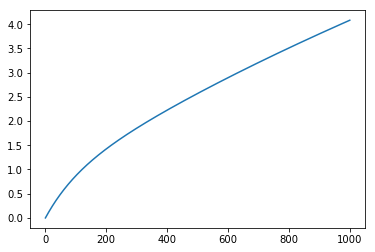

In [281]:
pl.plot(scen.effective_radiative_forcing)

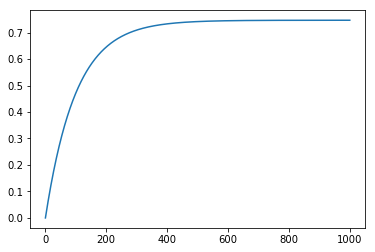

In [282]:
pl.plot(cfc12.effective_radiative_forcing)

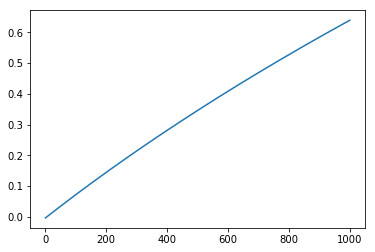

In [283]:
pl.plot(n2o.effective_radiative_forcing)

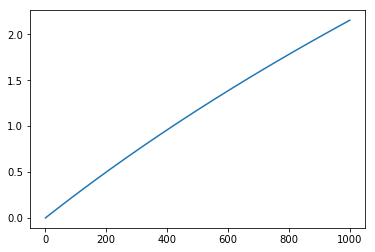

In [284]:
pl.plot(co2.effective_radiative_forcing)

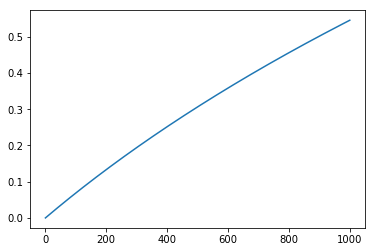

In [285]:
pl.plot(ch4.effective_radiative_forcing)

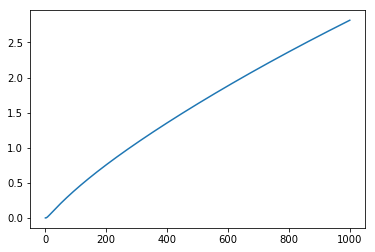

In [288]:
scen.calculate_temperature()
pl.plot(scen.temperature)

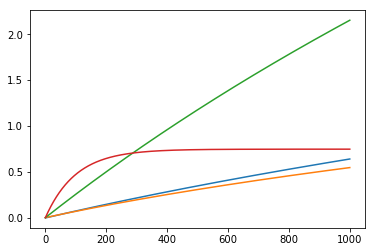

In [182]:
n2o.calculate_forcing(co2, ch4)
ch4.calculate_forcing(co2, n2o)
co2.calculate_forcing(ch4, n2o)
pl.plot(n2o.effective_radiative_forcing)
pl.plot(ch4.effective_radiative_forcing)
pl.plot(co2.effective_radiative_forcing)
pl.plot(cfc12.effective_radiative_forcing)
#cfc12.effective_radiative_forcing

In [ ]:
co2.concentrations

In [ ]:
ch4.set_emissions(np.ones(1000)*200 * unit.Mt / unit.year,
                  natural = 190.00 * unit.Mt / unit.year)
#cfc12.set_emissions([500]*1000 * unit.kt / unit.year,
#                  natural = 0.00 * unit.kt / unit.year)
#cfc12.set_emissions(500 * unit.kt / unit.year,
#                  natural = 0.00 * unit.kt / unit.year)
ch4.set_lifetime(9.3 * unit.years)
ch4.calculate_concentrations()
pl.plot(ch4.time_bounds, ch4.concentrations.to('ppb'))

In [ ]:
unit.K